# BioConvert 
## Materials for manuscripts

In [78]:
from bioconvert.core.registry import Registry
import os
import subprocess
from pylab import *

from IPython.display import Image
rcParams['figure.figsize'] = (10,7)
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.size'] = 12

In [47]:
os.makedirs("manuscripts", exist_ok=True)

# Histogram number of methods per conversion

Number of formats: 49
Number of converters: 100
Number of methods : 155


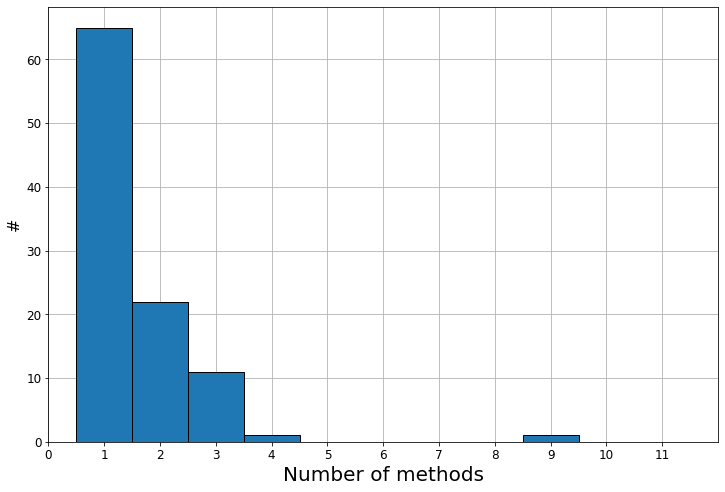

In [60]:
r = Registry()
info = r.get_info()

# The available unique converters
converters = [x for x in info.items()]

# the number of methods per converter
data = [info[k] for k, v in info.items()]

# the number of formats
A1 = [y for x in list(r.get_conversions()) for y in x[0]]
A2 = [y for x in list(r.get_conversions()) for y in x[1]]
formats = set(A1 + A2)

print("Number of formats: {}".format(len(formats)))
print("Number of converters: {}".format(len(converters)))
print("Number of methods : {}".format(sum(data)))

hist(data, range(12), ec="k", zorder=2, align="left")
xlim([0,12])
xticks(range(12), range(12))
xlabel("Number of methods", fontsize=20)
ylabel("#", fontsize=16)
grid(zorder=-1)

for ext in ['png', 'svg', 'eps', 'pdf']:
    savefig(f"manuscripts/hist_data.{ext}", dpi=200)

# Graph clustered

In [15]:
from bioconvert.core.graph import create_graph


In [16]:
_ = create_graph("manuscripts/graph_clustered_conversion.png", use_singularity=False, include_subgraph=True)

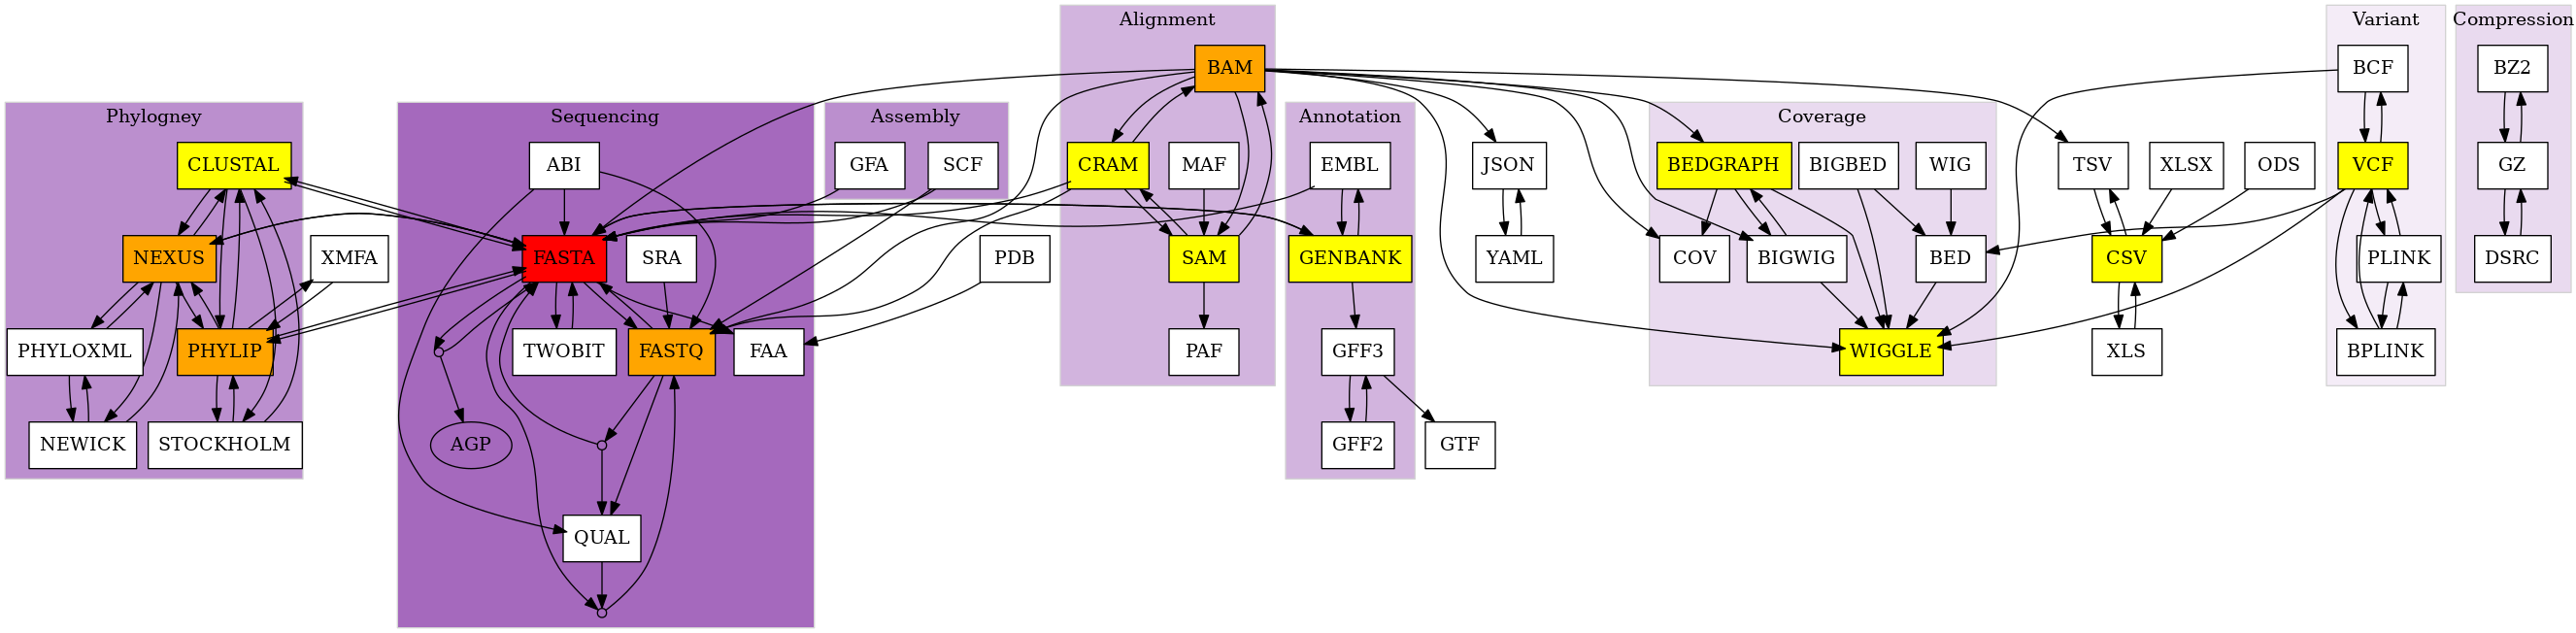

In [17]:
Image(filename="manuscripts/graph_clustered_conversion.png")

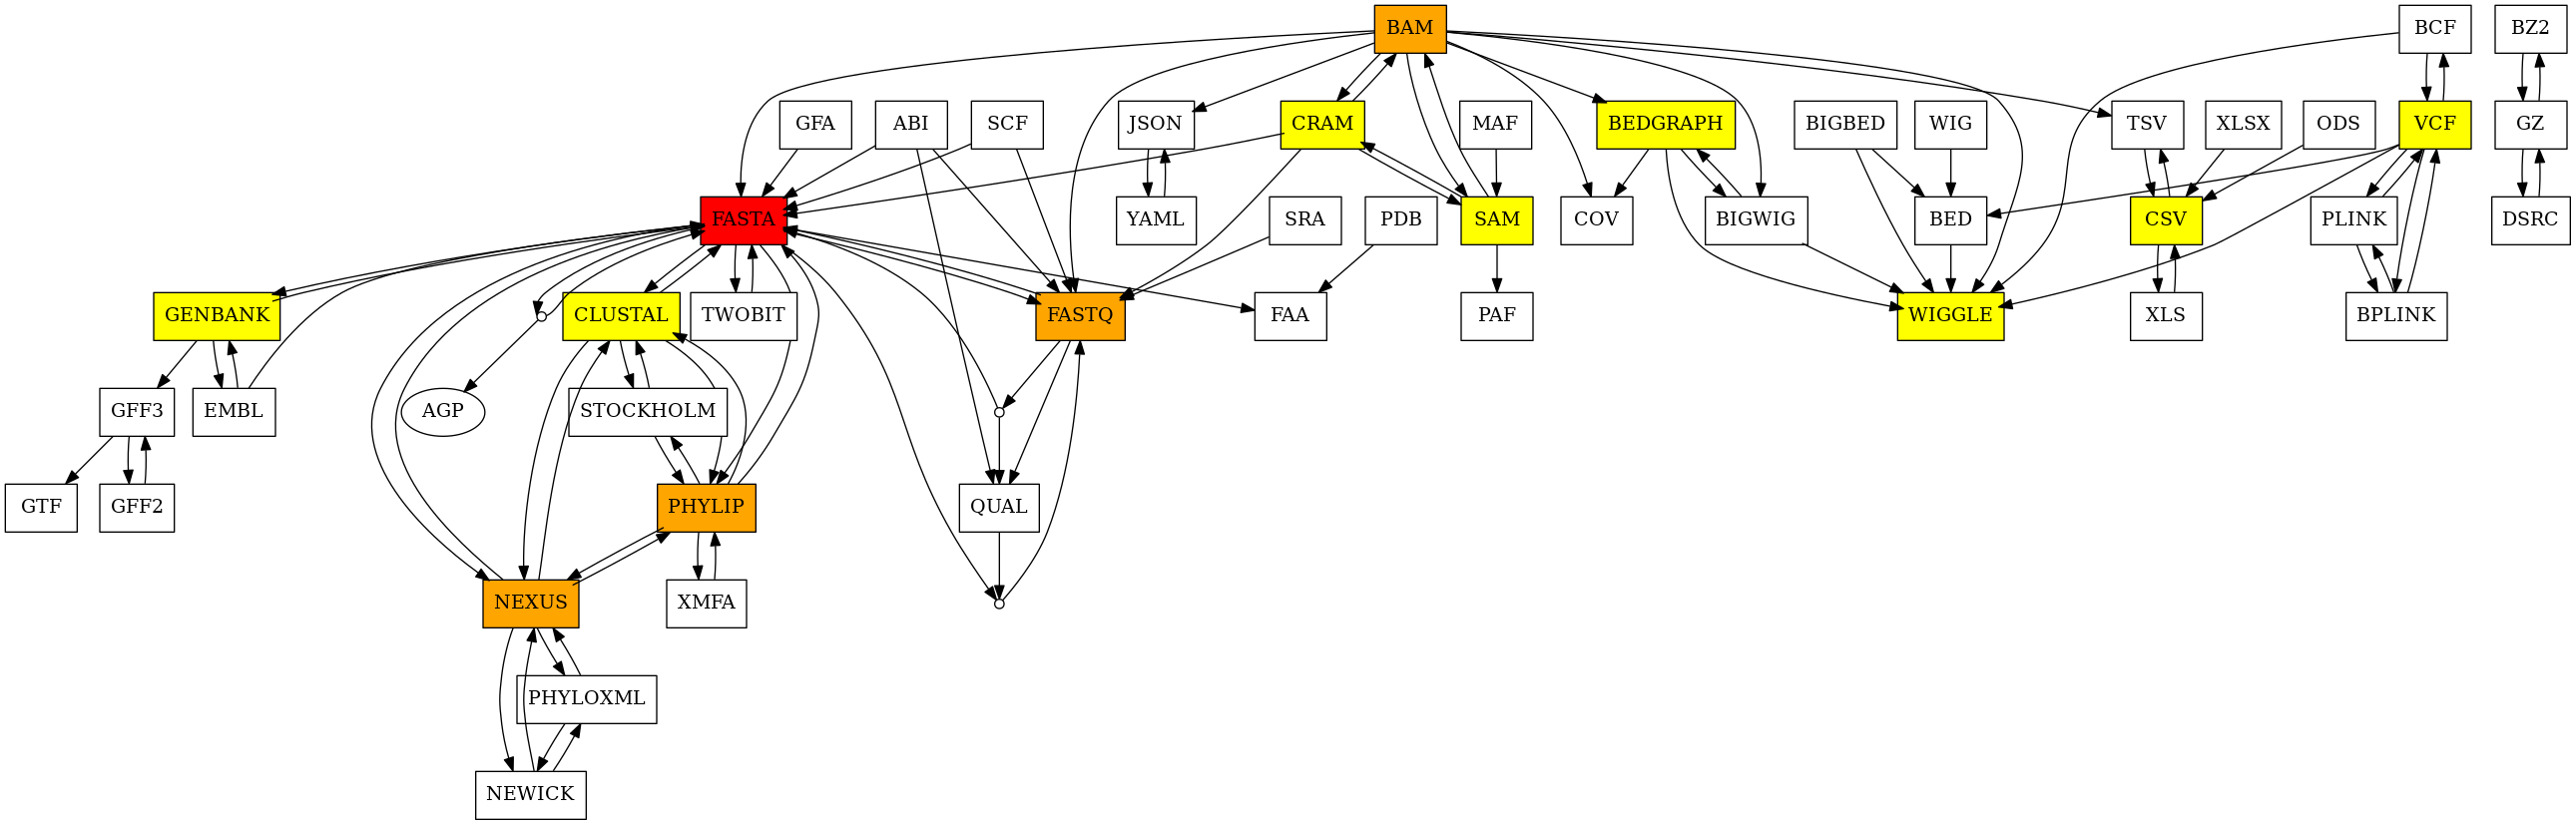

In [49]:
_ = create_graph("manuscripts/graph_conversion.png", use_singularity=False)
Image(filename="manuscripts/graph_conversion.png")

# Benchmarking


# Benchmarking FastQ2Fasta (simulated data)
## Input/Output data is not compressed

Evaluating method seqtk: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]


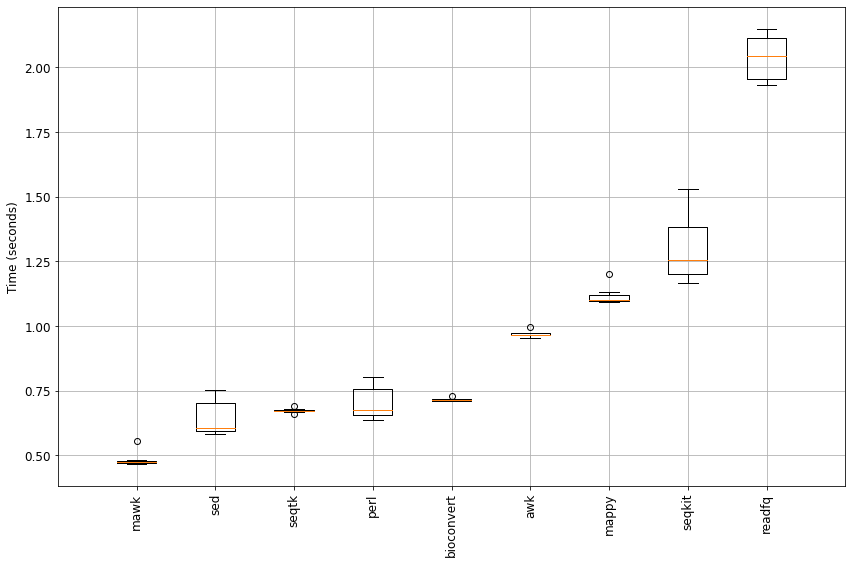

In [50]:
# Generate the dummy data, saving the results in a temporary file
from easydev import TempFile
from bioconvert.simulator.fastq import FastqSim

infile = TempFile(suffix=".fastq")
outfile = TempFile(suffix=".fasta")
fs = FastqSim(infile.name)
fs.nreads = 1000000 # 1,000,000 by default
fs.simulate()

# Perform the benchmarking
c = FASTQ2FASTA(infile.name, outfile.name)
c.boxplot_benchmark(N=10)

infile.delete()
outfile.delete()
savefig("manuscripts/benchmark_fastq2fasta_uncompressed_1000000.png")

## Same benchmark as above with compresssed input fastq file  (Figure 4)

Evaluating method seqtk: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


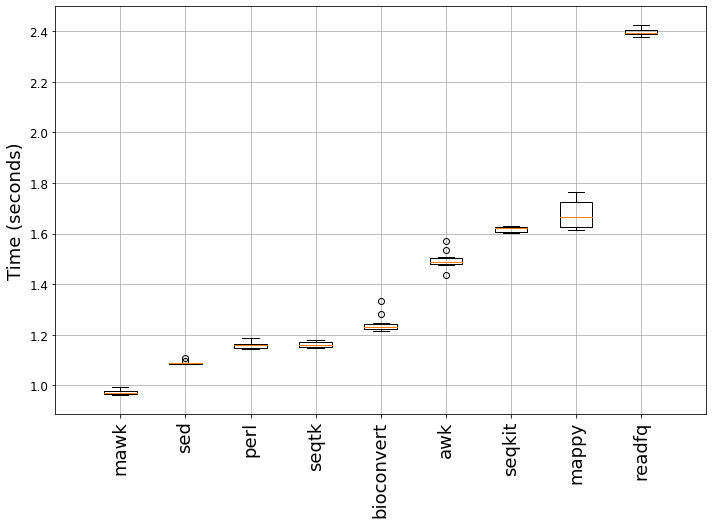

In [80]:

infile = TempFile(suffix=".fastq")
outfile = TempFile(suffix=".fasta")
fs = FastqSim(infile.name)
fs.nreads = 1000000 # 1,000,000 by default
fs.simulate()

cmd = f"pigz {infile.name}"
import subprocess
subprocess.run(cmd.split())
# Perform the benchmarking
c = FASTQ2FASTA(infile.name + ".gz", outfile.name)
c.boxplot_benchmark(N=10)

# here, just to tweak the fontsize of labels and ticks for the paper.
data = c._benchmark.results
methods = sorted(data, key=lambda x: mean(data[x]))
xticks(*zip(*enumerate(methods, start=1)), rotation=90, fontsize=18)
ylabel('Time (seconds)', fontsize=18)
# cleanup
cmd = f"unpigz {infile.name}"
subprocess.run(cmd.split())

infile.delete()
outfile.delete()
savefig("manuscripts/benchmark_no_compression.png", dpi=200)
savefig("manuscripts/benchmark_no_compression.pdf", dpi=200)


# Multi benchmark

First, we can download some test data that are posted on Zenodo

In [55]:
! wget https://zenodo.org/record/6405971/files/measles.sorted.bam -O inputs/test.bam
! wget https://zenodo.org/record/6405971/files/measles.sorted.bam.bai -O inputs/test.bam.bai


--2022-10-17 11:26:14--  https://zenodo.org/record/6405971/files/measles.sorted.bam
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68393900 (65M) [application/octet-stream]
Saving to: ‘inputs/test.bam’

inputs/test.bam     100%[===================>]  65.22M  6.45MB/s    in 14s     

2022-10-17 11:26:29 (4.62 MB/s) - ‘inputs/test.bam’ saved [68393900/68393900]

--2022-10-17 11:26:29--  https://zenodo.org/record/6405971/files/measles.sorted.bam.bai
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96 [application/octet-stream]
Saving to: ‘inputs/test.bam.bai’

inputs/test.bam.bai 100%[===================>]      96  --.-KB/s    in 0s      

2022-10-17 11:26:30 (7.98 MB/s) - ‘inputs/test.bam.bai’ saved [96/96]



Then, we run the same benachmark as before using the bioconvert command;
However, we will launch it several times (benchmark_num=5) and gather results as josn files into ./json

In [95]:
from tqdm import tqdm

benchmark_num = 5
for i in tqdm(range(benchmark_num), position=1):
    cmd = f"bioconvert bam2sam -b -N 10 -T json/test_bam2sam_{i} inputs/test.bam outputs/test.sam -f "
    subprocess.run(cmd.split(), stderr=subprocess.PIPE)


 20%|████████████████████████▍                                                                                                 | 1/5 [03:56<15:44, 236.08s/it]


KeyboardInterrupt: 

Here we gather the different json files into a single data structure

In [82]:
import pandas as pd

df = pd.read_json("json/test_bam2sam_0.json")

# Creation of another column containing the benchmarking number
df = df.assign(Benchmark=1)
 
for i in range(1, int(benchmark_num)):
    # open and read JSON file
    df_temp = pd.read_json(f"json/test_bam2sam_{i}.json")

    # Creation of another column containing the benchmarking number
    df_temp = df_temp.assign(Benchmark=i + 1)
 
    # Concatenation of the two JSON objects
    df = pd.concat([df, df_temp], axis=0)
    # The index is reset to avoid problems when exporting the final JSON file
df.reset_index(inplace=True, drop=True)
# Creation of the path variable which will be used to give the name of the output JSON file
# Exporting the JSON object to a JSON file
df.to_json("json/test_bam2sam.json", indent=4)


Finally, we look at the results

- By comparing the picard method with the best one (pysam), we check H0: True with corrected P-value: 7.373991102518177e-84
- By comparing the sambamba method with the best one (pysam), we check H0: True with corrected P-value: 9.297244709639994e-13
- By comparing the samtools method with the best one (pysam), we check H0: True with corrected P-value: 5.711426553171635e-60


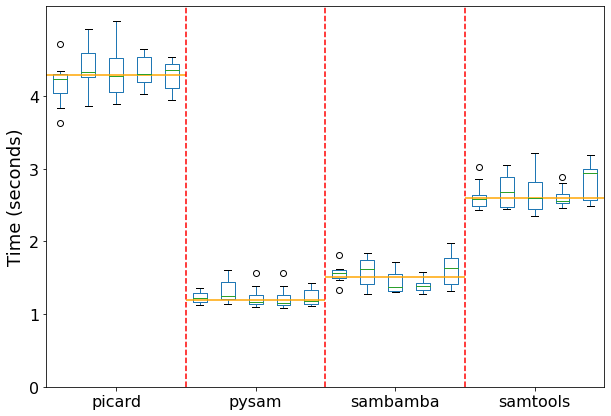

In [92]:
from bioconvert.core.benchmark import plot_multi_benchmark_max
_ = plot_multi_benchmark_max("json/test_bam2sam.json", "manuscripts/benchmark_bam2sam.png") 
_ = ylabel("Time (seconds)", fontsize=18)
_ = yticks(range(5), range(5), fontsize=16)
_ = xticks([3,8,13,18], ['picard', 'pysam', 'sambamba', 'samtools'], fontsize=16)

savefig("manuscripts/multi_benchmark_bam2sam_samtools1_7.png", dpi=200)
savefig("manuscripts/multi_benchmark_bam2sam_samtools1_7.pdf", dpi=200)

# Using samtools 1.15 from damona singularity

- By comparing the pysam method with the best one (samtools), we check H0: True with corrected P-value: 6.242048328741146e-22
- By comparing the sambamba method with the best one (samtools), we check H0: True with corrected P-value: 1.1394544053461425e-36


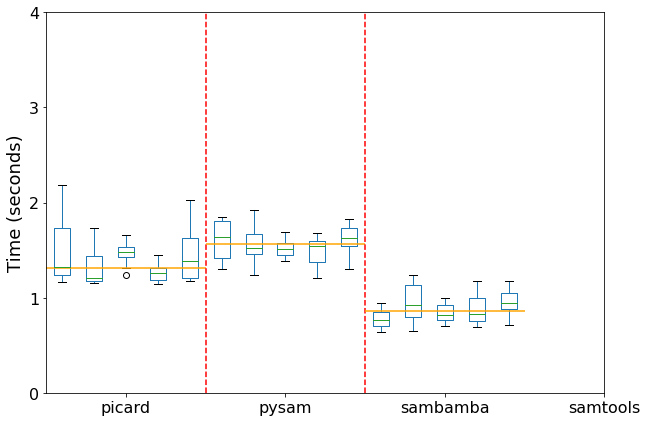

In [93]:

  
df = pd.read_json("json2/test_bam2sam_0.json")

# Creation of another column containing the benchmarking number
df = df.assign(Benchmark=1)

for i in range(1, int(benchmark_num)):
    # open and read JSON file
    df_temp = pd.read_json(f"json2/test_bam2sam_{i}.json")
   
    # Creation of another column containing the benchmarking number
    df_temp = df_temp.assign(Benchmark=i + 1)
   
    # Concatenation of the two JSON objects
    df = pd.concat([df, df_temp], axis=0)
    # The index is reset to avoid problems when exporting the final JSON file
df.reset_index(inplace=True, drop=True)
# Creation of the path variable which will be used to give the name of the output JSON file
# Exporting the JSON object to a JSON file
df.to_json("json2/test_bam2sam.json", indent=4)
_ = plot_multi_benchmark_max("json2/test_bam2sam.json", 
                             "manuscripts/benchmark2_bam2sam.png")
_ = ylabel("Time (seconds)", fontsize=18)
_ = yticks(range(5), range(5), fontsize=16)
_ = xticks([3,8,13,18], ['picard', 'pysam', 'sambamba', 'samtools'], fontsize=16)
savefig("manuscripts/multi_benchmark_bam2sam_samtools1_15.png", dpi=200)
savefig("manuscripts/multi_benchmark_bam2sam_samtools1_15.pdf", dpi=200)

# Dec 2022. picard included

In [10]:
from tqdm import tqdm

benchmark_num = 5
for i in tqdm(range(benchmark_num), position=1):
    cmd = f"bioconvert bam2sam -b -N 10 -T json/test_bam2sam_{i} inputs/test.bam outputs/test.sam -f"
    subprocess.run(cmd.split())


Evaluating method picard:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/anaconda/bin/picard: line 5: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8): No such file or directory
INFO	2022-12-21 16:39:15	SamFormatConverter	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    SamFormatConverter -I inputs/test.bam -O outputs/test.sam
**********


16:39:15.938 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/usr/local/anaconda/share/picard-2.26.6-0/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Wed Dec 21 16:39:15 UTC 2022] SamFormatConverter INPUT=inputs/test.bam OUTPUT=outputs/test.sam    VERBOSITY=INFO QUIET=false VALIDATION_STRINGENCY=STRICT COMPRESSION_LEVEL=5 MA

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- By comparing the picard method with the best one (pysam), we check H0: True with corrected P-value: 7.373991102518177e-84
- By comparing the sambamba method with the best one (pysam), we check H0: True with corrected P-value: 9.297244709639994e-13
- By comparing the samtools method with the best one (pysam), we check H0: True with corrected P-value: 5.711426553171635e-60


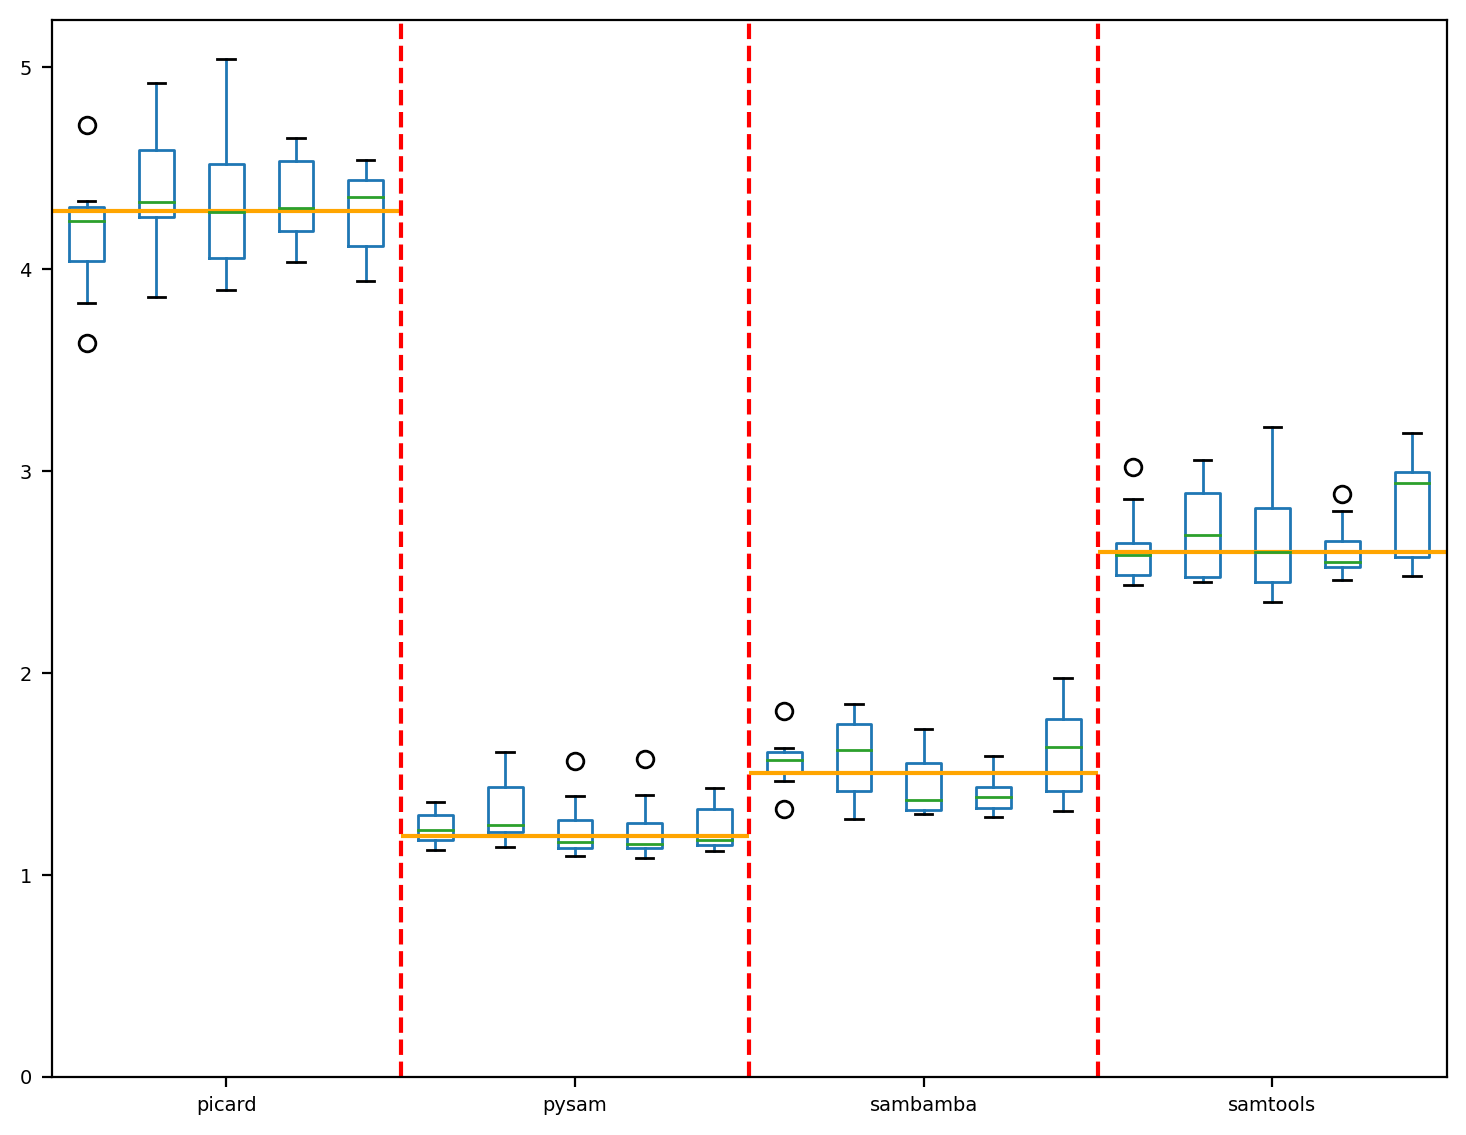

In [13]:
from bioconvert.core.benchmark import plot_multi_benchmark_max

  
df = pd.read_json("json/test_bam2sam_0.json")

# Creation of another column containing the benchmarking number
df = df.assign(Benchmark=1)

for i in range(1, int(benchmark_num)):
    # open and read JSON file
    df_temp = pd.read_json(f"json/test_bam2sam_{i}.json")
   
    # Creation of another column containing the benchmarking number
    df_temp = df_temp.assign(Benchmark=i + 1)
   
    # Concatenation of the two JSON objects
    df = pd.concat([df, df_temp], axis=0)
    # The index is reset to avoid problems when exporting the final JSON file
df.reset_index(inplace=True, drop=True)
# Creation of the path variable which will be used to give the name of the output JSON file
# Exporting the JSON object to a JSON file
df.to_json("json/test_bam2sam_picard.json", indent=4)
_ = plot_multi_benchmark_max("json/test_bam2sam_picard.json", 
                             "manuscripts/benchmark2_bam2sam_with_picard.png")